<h1 align="center"> <b> Customer lead generator: Predicting model </b> </h1>

<center> <img src="images/Bild1.png" width="200px"> </center>

### Table of Contents
* [Model selection](#Model-selection)
* [Metric](#Metric)
* [Preprocessing](#Preprocessing)
* [Modelling](#Modelling)
* [Recommendations for the stakeholder](#Recommendations-for-the-stakeholder)
* [Final words](#Final-words)

### Model selection

In this notebook, a preprocessed model is implemented to predict customer leads based on the provided data and the previously performed [EDA](EDA.ipynb). As mentioned there, only 2.5% of all data shows *b_in_kontakt_gewesen* = 1. The observations with *b_in_kontakt_gewesen* = 0 all have *b_gekauft_gesamt* = 0. In fact, all these observations are still potential customers. Thus, the data with *b_in_kontakt_gewesen* = 0 can be regarded without the label *b_in_kontakt_gewesen*. This challenge is therefore dealing with a huge amount of **unlabelled data**. This leads to the conclusion that chosing a simple model to avoid extensive overfitting is absolutely important. Using fewer training data still poses the risk of using a model with high bias.

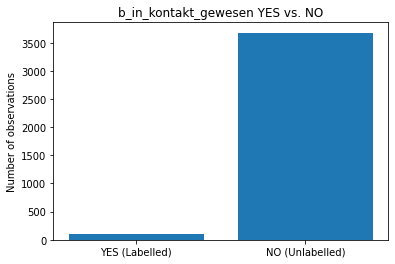

In [307]:
plt.bar(["YES (Labelled)","NO (Unlabelled)"],[95,3678])  
plt.ylabel('Number of observations') 
plt.title('b_in_kontakt_gewesen YES vs. NO')
plt.show()

To deal with unlablled data, a **semi-supervised** approach was chosen:
The labelled data with *b_in_kontakt_gewesen* = 1 are split into a training and test set. Logistic regression was used to build a model using the training data. In a next step, this model was used to label the unlabelled data in several steps. This process was used to gain a refined model. At last, the test data were given as input to this refined model.

### Metric

A high recall is the most reasonable metric for this situation. For selling products it is vital not to miss any potential customer. On the other hand, it is also not bad to contact more people. Although more resources and manhours are spent, a first contact is also a good opportunity to spread the company's name for recommendations and possible purchases in the future. Hence, a high recall is aimed for this task, also maintaining a proper accuracy and a f1-score.

### Preprocessing

The data were preprocessed before the implementation of the model:
* *fakeID* as Index
* Split data into labelled and unlabelled
* Drop labels
* Feature and target split
* Train, test split
* Standardize all numerical features

In [353]:
# Import libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, plot_confusion_matrix

In [449]:
# Load the data

df = pd.read_csv("data/CustomerData_clean.csv")

# FakeID as Index

df.set_index("fakeID", inplace=True)

# Split into labelled and unlablled data

df_lab = df[df["b_in_kontakt_gewesen"] != 0]
df_unlab = df[df["b_in_kontakt_gewesen"] == 0]

# The features are saved in X and the target column in y, for both labelled and unlabelled data

X_lab = df_lab.drop(columns="b_gekauft_gesamt")
y_lab = df_lab["b_gekauft_gesamt"]
X_unlab = df_unlab.drop(columns="b_gekauft_gesamt")
y_unlab = df_unlab["b_gekauft_gesamt"]

# Drop all the labels b_in_kontakt_gewesen

X_lab = X_lab.drop(columns="b_in_kontakt_gewesen")
y_lab = y_lab.drop(columns="b_in_kontakt_gewesen")
X_unlab = X_unlab.drop(columns="b_in_kontakt_gewesen")
y_unlab = y_unlab.drop(columns="b_in_kontakt_gewesen")

# Train, test split on labelled data set 
X_lab_train, X_lab_test, y_lab_train, y_lab_test = train_test_split(X_lab, y_lab, test_size=0.3, shuffle=False)

The standardization is fitted with all the unlabelled data and with the resulting parameters, the unlabelled and labelled (train and test) data are transformed. This is because there are more unlabelled data and a better fit can be obtained.

In [450]:
# Scale train, test and unlabelled data. The continuous numerical features are saved as cont.

cont = ["q_OpeningDays","q_2017 Average Household Size","q_2017 Total Households","q_5th Quint by Total HH","q_2017 Purchasing Power: Per Capita","q_Uni by Total Pop","q_2017 Medical Products: Per Capita","spec_number"]
scaler = StandardScaler()

# Fit and transformation of the unlabelled data

X_unlab[cont] = scaler.fit_transform(X_unlab[cont])

# Transformation of the remaining data

X_lab_train[cont] = scaler.transform(X_lab_train[cont])
X_lab_test[cont] = scaler.transform(X_lab_test[cont])

### Modelling

The logistic regression is a simple binary classifier. Firstly, the model is trained to predict the test data with a probability threshold of 0.75. The regularization parameter C is chosed to be 0.5. After that, self-training is used to predict the unlabelled data. A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is shown to illustrate the true and false positives and negatives.

Train f1 Score: 0.5483870967741935
Test f1 Score: 0.4444444444444445
Accuracy:  0.4827586206896552
Recall: 0.4857142857142857


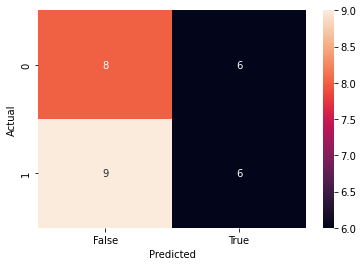

In [451]:
# Logistic regression (scikit-learn)

clf = LogisticRegression(C=0.5,max_iter=1000)
clf.fit(X_lab_train, y_lab_train)
#y_hat_test = clf.predict(X_lab_test)
#y_hat_train = clf.predict(X_lab_train)
y_hat_test = (clf.predict_proba(X_lab_test)[:,1] >= 0.75).astype(bool)
y_hat_train = (clf.predict_proba(X_lab_train)[:,1] >= 0.75).astype(bool)

train_f1 = f1_score(y_lab_train, y_hat_train)
test_f1 = f1_score(y_lab_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# Confusion Matrix Plot

confusion_matrix = pd.crosstab(y_lab_test, y_hat_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);
print('Accuracy: ',metrics.accuracy_score(y_lab_test, y_hat_test))
print("Recall: " + str(recall_score(y_lab_test, y_hat_test, average='macro')))

In the following section, the self-learning step is carried out. The code is borrowed from [towardsdatascience.com](https://towardsdatascience.com/a-gentle-introduction-to-self-training-and-semi-supervised-learning-ceee73178b38).

In [ ]:
# Initiate iteration counter

iterations = 0

# Containers to hold f1_scores and # of pseudo-labels

train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop

high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels

while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    
    clf = LogisticRegression(C=0.5, max_iter=1000)
    clf.fit(X_lab_train, y_lab_train)
    #y_hat_train = clf.predict(X_lab_train)
    #y_hat_test = clf.predict(X_lab_test)
    y_hat_train = (clf.predict_proba(X_lab_train)[:,1] >= 0.75).astype(int)
    y_hat_test = (clf.predict_proba(X_lab_test)[:,1] >= 0.75).astype(int)
    

    # Calculate and print iteration # and f1 scores, and store f1 scores
    
    train_f1 = f1_score(y_lab_train, y_hat_train)
    test_f1 = f1_score(y_lab_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    print('Test Accuracy: ',metrics.accuracy_score(y_lab_test, y_hat_test))
    print("Test Recall: " ,recall_score(y_lab_test, y_hat_test, average='macro'))
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlab)
    #preds = clf.predict(X_unlab)
    preds = (clf.predict_proba(X_unlab)[:,1] >= 0.75).astype(int)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlab.index
    
    if iterations == 0:
        store = df_pred_prob
    
    # Separate predictions with > 70% probability
    
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.70],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.70]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    
    X_lab_train = pd.concat([X_lab_train, X_unlab.loc[high_prob.index]], axis=0)
    y_lab_train = pd.concat([y_lab_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    
    X_unlab = X_unlab.drop(index=high_prob.index)
    print(f"{len(X_unlab)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    
    iterations += 1

### Recommendations for the stakeholder

After implementing a machine learning model to get a lead generator, a actual recommendation is part of the work. Here, a list of the top ten most promising contacts (*fakeID*) is given.

In [482]:
topten = tuple(store.sort_values("prob_1", ascending = False).head(10).index)

print(f"Please contact the following ten contacts, it migh be a successful meeting! \n {topten}")

Please contact the following ten contacts, it migh be a successful meeting! 
 ('278_3711', '861_6272', '727_8789', '380_4886', '555_7226', '595_7573', '756_9216', '247_3395', '757_5373', '320_4295')


The stakeholder might be interested in the feature importance. This is shown here:

In [488]:
# Feature importance

coeff = clf.coef_
coeff = pd.Series(coeff.flatten(order='C'),name="Coefficients")

coeff = pd.Series(coeff).to_frame()

feature_importance = pd.Series(X_lab_test.columns, name="Features").to_frame()
feature_importance = pd.concat([feature_importance,coeff],axis=1)


feature_importance.set_index("Features", inplace=True)
feature_importance.sort_values("Coefficients", ascending=False, inplace=True)

print(f"The most important features are (descending order): {list(feature_importance.index)}")



The most important features are (descending order): ['b_specialisation_f', 'b_specialisation_a', 'b_specialisation_j', 'b_specialisation_b', 'q_2017 Total Households', 'spec_number', 'b_specialisation_d', 'b_specialisation_c', 'q_Uni by Total Pop', 'q_2017 Medical Products: Per Capita', 'q_2017 Average Household Size', 'b_specialisation_i', 'q_2017 Purchasing Power: Per Capita', 'b_specialisation_g', 'b_specialisation_e', 'b_specialisation_h', 'q_5th Quint by Total HH', 'q_OpeningDays']


### Final words

A semi-supervised self-learning approach was implemented to solve the huge amount of unlabelled data. However, the accuracy and recall values are not ideal. More labelled data, i.e. *b_in_kontakt_gewesen* would be helpful. Nevertheless, I would really love to get some tips to improve the model and my work.